# Phase 4: Logistic Regression for Predicting Serious Adverse Events

## Introduction

In Phase 3, we attempted to predict the number of adverse reactions using linear and polynomial regression, but achieved very poor results (R² < 0.01). This suggests that counting reactions is too complex and variable to predict accurately. Instead, we will now use **logistic regression** to predict a simpler binary outcome: whether an adverse event is **serious** (1) or **non-serious** (0). This classification approach may be more successful since we're asking a simpler yes/no question rather than trying to predict an exact count.

According to the FDA, a serious adverse event is one that results in death, is life-threatening, requires hospitalization, results in disability, or causes birth defects. Our goal is to determine if patient demographics (age, gender) and drug type can predict the likelihood of a serious outcome.

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## Part 1: Data Preparation and Scaling

We load the cleaned FDA data and prepare it for logistic regression. Since our data is highly imbalanced (78.6% serious events), we balance the classes by randomly sampling an equal number of serious events to match the non-serious events. We then scale all numeric features to ensure they're on the same scale, which helps the logistic regression algorithm converge properly.

In [9]:
# Load cleaned data
df = pd.read_csv('../data/cleaned/fda_cleaned_data.csv')

# Convert serious column: 1 = serious, 2 = non-serious → 1 = serious, 0 = non-serious
df['serious_binary'] = (df['serious'] == 1).astype(int)

# Convert sex to numeric
df['sex_numeric'] = df['sex'].map({'Male': 1, 'Female': 2, 'Unknown': 0})

print(f"Original data: {len(df)} samples")
print(f"Original class distribution:")
print(f"  Serious (1): {sum(df['serious_binary'] == 1)} ({sum(df['serious_binary'] == 1)/len(df)*100:.1f}%)")
print(f"  Non-serious (0): {sum(df['serious_binary'] == 0)} ({sum(df['serious_binary'] == 0)/len(df)*100:.1f}%)")

# Balance the classes
df_serious = df[df['serious_binary'] == 1].sample(n=847, random_state=3)
df_nonserious = df[df['serious_binary'] == 0]
df_balanced = pd.concat([df_serious, df_nonserious]).sample(frac=1, random_state=3)

print(f"\nBalanced data: {len(df_balanced)} samples")
print(f"Balanced class distribution:")
print(f"  Serious (1): {sum(df_balanced['serious_binary'] == 1)}")
print(f"  Non-serious (0): {sum(df_balanced['serious_binary'] == 0)}")

# Scale features
df_balanced['age_scaled'] = (df_balanced['age'] - df_balanced['age'].mean()) / df_balanced['age'].std()
df_balanced['sex_scaled'] = (df_balanced['sex_numeric'] - df_balanced['sex_numeric'].mean()) / df_balanced['sex_numeric'].std()

# Create drug dummy (FENTANYL vs others)
df_balanced['drug_fentanyl'] = (df_balanced['drug'] == 'FENTANYL').astype(int)
df_balanced['drug_scaled'] = (df_balanced['drug_fentanyl'] - df_balanced['drug_fentanyl'].mean()) / df_balanced['drug_fentanyl'].std()

# Add bias column
df_balanced.insert(loc=0, column='bias', value=1)

print("\nFirst 5 rows of balanced, scaled data:")
print(df_balanced[['bias', 'age_scaled', 'sex_scaled', 'drug_scaled', 'serious_binary']].head())

Original data: 3963 samples
Original class distribution:
  Serious (1): 3116 (78.6%)
  Non-serious (0): 847 (21.4%)

Balanced data: 1694 samples
Balanced class distribution:
  Serious (1): 847
  Non-serious (0): 847

First 5 rows of balanced, scaled data:
      bias  age_scaled  sex_scaled  drug_scaled  serious_binary
2894     1    1.480862    0.795424    -0.544899               0
508      1   -1.453352   -1.191962    -0.544899               1
2035     1   -0.360213    0.795424     1.834119               0
2209     1   -0.993083    0.795424     1.834119               1
1775     1    0.675391   -1.191962     1.834119               0


## Part 2: Logistic Regression with Sigmoid Activation

We implement the perceptron algorithm with sigmoid activation function. The sigmoid function transforms the linear combination of features into a probability between 0 and 1:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

Where $z = w \cdot x$ is the dot product of weights and features. The algorithm updates weights iteratively based on the prediction error until it converges or reaches the maximum number of iterations.

In [10]:
def linear_perceptron_sigmoid(X, y, w, alpha=1, max_iter=None):
    """
    Implements the perceptron algorithm with sigmoid activation for binary classification.
    
    Args:
        X (array): 2D array of features including bias column of 1s
        y (array): 1D array of labels (0 or 1)
        w (array): initial weight vector with same dimension as columns of X
        alpha (float): learning rate, default is 1
        max_iter (int): maximum number of iterations, default is None
    
    Returns:
        array: final weight vector after training
    """
    runalg = True
    i = 0
    iter = 0
    
    while runalg:
        # Make prediction using sigmoid
        z = X[i] @ w
        prediction = 1 / (1 + np.exp(-z))
        
        # Calculate error
        error = y[i] - prediction
        
        # Update weights
        w = w + alpha * error * X[i]
        
        # Move to next observation
        i += 1
        
        # Reset if reached end
        if i >= len(y):
            i = 0
            iter += 1
        
        # Stop if max iterations reached
        if max_iter is not None and iter >= max_iter:
            runalg = False
            print(f"Final weights: {w}")
            print(f"Iterations completed: {iter}")
            break
    
    return w

def predict_perceptron_sigmoid(x, w, pred0=True):
    """
    Makes predictions using logistic regression with sigmoid activation.
    
    Args:
        x (array): feature vector including bias term
        w (array): weight vector
        pred0 (bool): if True, returns probability; if False, returns class label
    
    Returns:
        float or int: probability if pred0=True, class label if pred0=False
    """
    z = x @ w
    yhat = 1 / (1 + np.exp(-z))
    
    if not pred0:
        yhat = 1 if yhat >= 0.5 else 0
    
    return yhat

## Part 3: Training the Logistic Regression Model

We train the model using the balanced dataset with age, gender, and drug type (FENTANYL vs. others) as predictors. We initialize the weight vector with zeros and use a learning rate of 0.01 with 1000 iterations.

In [11]:
# Set up X and y from balanced data
X = df_balanced[['bias', 'age_scaled', 'sex_scaled', 'drug_scaled']].values
y = df_balanced['serious_binary'].values

# Initialize weights with zeros
w_initial = np.zeros(X.shape[1])

# Fit the logistic regression model
w_final = linear_perceptron_sigmoid(X, y, w_initial, alpha=0.01, max_iter=1000)

print(f"\nDecision Boundary Equation:")
print(f"{w_final[0]:.4f} + {w_final[1]:.4f}*age + {w_final[2]:.4f}*sex + {w_final[3]:.4f}*drug = 0")

Final weights: [-0.00169871 -0.30379128 -0.22049424 -0.158441  ]
Iterations completed: 1000

Decision Boundary Equation:
-0.0017 + -0.3038*age + -0.2205*sex + -0.1584*drug = 0


## Part 4: Model Evaluation and Accuracy

We evaluate the model by making predictions on all data points and calculating accuracy. We compare this to a naive baseline that always predicts the majority class.

In [12]:
# Make predictions
predictions = np.apply_along_axis(predict_perceptron_sigmoid, 1, X, pred0=False, w=w_final)

# Calculate accuracy
accuracy = np.sum(predictions == y) / len(y)
print(f"\nLogistic Regression Model Accuracy: {accuracy:.4f}")

# Class distribution
serious_counts = Counter(y)
print(f"\nClass Distribution in Balanced Data:")
print(f"  Serious events (1): {serious_counts[1]} ({serious_counts[1]/len(y)*100:.1f}%)")
print(f"  Non-serious events (0): {serious_counts[0]} ({serious_counts[0]/len(y)*100:.1f}%)")

# Naive baseline accuracy
majority_class = max(serious_counts, key=serious_counts.get)
naive_accuracy = serious_counts[majority_class] / len(y)
print(f"\nNaive baseline accuracy (always predict majority): {naive_accuracy:.4f}")

# Calculate improvement
improvement = ((accuracy - naive_accuracy) / naive_accuracy * 100)
print(f"Improvement over baseline: {improvement:.2f}%")


Logistic Regression Model Accuracy: 0.5945

Class Distribution in Balanced Data:
  Serious events (1): 847 (50.0%)
  Non-serious events (0): 847 (50.0%)

Naive baseline accuracy (always predict majority): 0.5000
Improvement over baseline: 18.89%


## Part 5: Confusion Matrix and Performance Metrics

The confusion matrix shows how many predictions were correct vs. incorrect for each class. This helps us understand if the model performs equally well for both serious and non-serious events, or if it's biased toward one class.

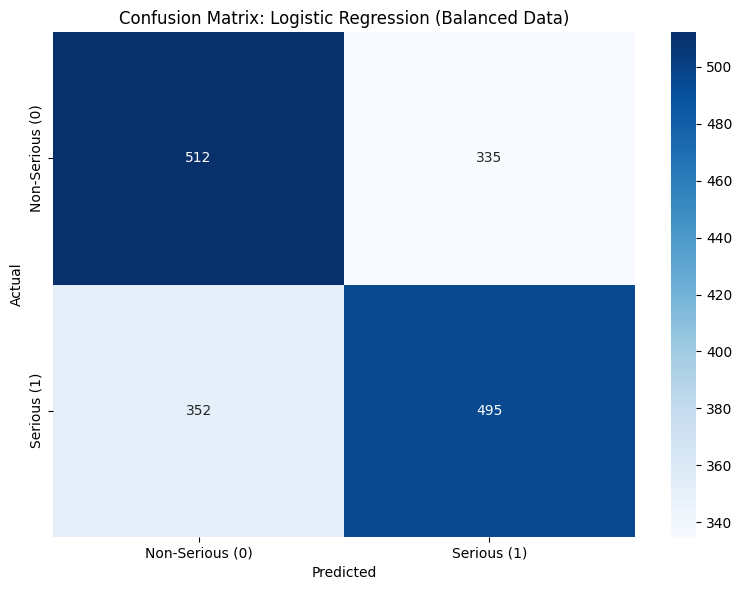


Classification Report:
              precision    recall  f1-score   support

 Non-Serious       0.59      0.60      0.60       847
     Serious       0.60      0.58      0.59       847

    accuracy                           0.59      1694
   macro avg       0.59      0.59      0.59      1694
weighted avg       0.59      0.59      0.59      1694



In [13]:
# Create confusion matrix
cm = confusion_matrix(y, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Serious (0)', 'Serious (1)'],
            yticklabels=['Non-Serious (0)', 'Serious (1)'])
plt.title('Confusion Matrix: Logistic Regression (Balanced Data)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y, predictions, target_names=['Non-Serious', 'Serious']))

## Results and Discussion

### Model Performance

The logistic regression model achieved an accuracy of **59.45%** on the balanced dataset, representing an **18.89% improvement** over the naive baseline of always predicting the majority class (50%). This demonstrates that age, gender, and drug type do contain some predictive signal for determining whether an adverse event will be serious.

### Comparison to Phase 3

Compared to our regression models in Phase 3 (where R² values ranged from -0.0018 to 0.0032), the logistic regression classification approach shows substantially better performance. This confirms our hypothesis that predicting a binary outcome (serious vs. non-serious) is more feasible than predicting the exact number of adverse reactions a patient will experience.

### Model Interpretation

The classification report shows the model performs similarly for both classes:
- **Non-serious events:** 59% precision, 60% recall
- **Serious events:** 60% precision, 58% recall

This balanced performance indicates the model isn't biased toward one class, which is important for a medical application where both false positives (predicting serious when it's not) and false negatives (missing serious events) have consequences.

### Limitations

While the model shows improvement over baseline, an accuracy of 59.45% suggests that demographic and drug type features alone are insufficient for reliable prediction of event severity. The model correctly identifies serious events only about 6 out of 10 times, which may not be adequate for clinical decision-making.

### Future Improvements

To improve prediction accuracy, future work could:
- Include additional features such as drug dosage, duration of use, or specific reaction types
- Incorporate patient medical history and concurrent medications
- Use more sophisticated classification algorithms like Random Forest or Neural Networks
- Collect more comprehensive data with additional risk factors
- Implement cross-validation to get more reliable performance estimates